In [1]:
# Basics
from glob import glob # finds pathnames
import os # Miscellaneous operating system interfaces
import sys
import random
import timeit
import imp
import gc

# Processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.ndimage import label as scipy_label
from scipy.ndimage import generate_binary_structure

# Image manipulation
import skimage

# Import Mask RCNN
sys.path.append('mrcnn')  # To find local version of the library
from config import Config
# Imp import to ensure loading the correct utils package
fp, pathname, description = imp.find_module('utils',['mrcnn'])
utils = imp.load_module('utils',fp,pathname,description)
import model as modellib
import visualize
from model import log
from imgaug import augmenters as iaa
# Plotting
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Paths
ROOT_DIR = 'C:/Users/HPDQ/Mask_RCNN/DATASET/severstal'
Train_Dir = os.path.join(ROOT_DIR, 'train_images/')
Test_Dir = os.path.join(ROOT_DIR, 'test_images/')

# Directory to save logs and trained model
MODEL_DIR = 'logs'

# Local path to trained weights file
# Trained_Weights = '../input/????.h5'

In [4]:
print (Train_Dir)

C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images/


In [3]:
class SteelConfig(Config):
    """Configuration for training on the steel dataset.
    Derives from the base Config class and overrides values specific
    to the steel dataset.
    """
    # Give the configuration a recognizable name
    NAME = "steel"

    # Train on 1 GPU and 1 image per GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 defect classes

    # Use small images (128x128) for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our objects tend to be small 
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images have few objects.
    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7
    
    # Number of epochs
    EPOCHS = 20
    
    # Steps per epoch
    STEPS_PER_EPOCH = 100

    # validation steps per epoch
    VALIDATION_STEPS = 5
    
    # Non-maximum suppression threshold for detection, default 0.3
    DETECTION_NMS_THRESHOLD = 0.3
    
    # Non-max suppression threshold to filter RPN proposals. default 0.7
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7
    
config = SteelConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         20
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE     

In [4]:
class SteelDataset(utils.Dataset):

    def load_steel(self, dataset_dir, files):
        """Load a subset of the Steel dataset.
        
        Input:
        dataset_dir: Root directory of the dataset.
        files: filenames of images to load
        
        Creates:
        image objects:
            source: source label
            image_id: id, used filename
            path: path + filename
            rle: rle mask encoded pixels, required for mask conversion
            classes: classes for the rle masks, required for mask conversion        
        """
        # Add classes.
        self.add_class("steel", 1, "defect1")
        self.add_class("steel", 2, "defect2")
        self.add_class("steel", 3, "defect3")
        self.add_class("steel", 4, "defect4")
        
        # Load annotations CSV
        annotations_train = pd.read_csv(r'C:\Users\HPDQ\Mask_RCNN\DATASET\severstal\train.csv')

        # Remove images without Encoding
        #annotations_train_Encoded = annotations_train[annotations_train['EncodedPixels'].notna()].copy()        
        annotations_train_Encoded = annotations_train
        # Split ImageId_ClassId
        #ImageId_ClassId_split = annotations_train_Encoded["ImageId_ClassId"].str.split("_", n = 1, expand = True)
        #annotations_train_Encoded['ImageId'] = ImageId_ClassId_split.loc[:,0]
        #annotations_train_Encoded['ClassId'] = ImageId_ClassId_split.loc[:,1]     

        for file in files:
            EncodedPixels = [annotations_train_Encoded['EncodedPixels'][annotations_train_Encoded['ImageId'] == file]]
            ClassID = (annotations_train_Encoded['ClassId'][annotations_train_Encoded['ImageId'] == file])

            self.add_image(
                source = "steel",
                image_id = file,  # use filename as a unique image id
                path = Train_Dir + '/' + file,
                rle = EncodedPixels,
                classes = ClassID)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Input:
        image_id: id of the image
        
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D int array of class IDs of the instance masks.
        """
        print(image_id)
        # If not a steel dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "steel":
            return super(self.__class__, self).load_mask(image_id)
        
        # Convert rle to single mask
        ClassIDIndex = 0
        ClassID = np.empty(0, dtype = int)
        maskarray = np.empty((256, 1600, 0), dtype = int)
        for rlelist in image_info['rle']:
            for row in rlelist:
                mask= np.zeros(1600 * 256 ,dtype=np.uint8)
                array = np.asarray([int(x) for x in row.split()])
                starts = array[0::2]-1
                lengths = array[1::2]    
                for index, start in enumerate(starts):
                    mask[int(start):int(start+lengths[index])] = 1
                mask = mask.reshape((256,1600), order='F')
                # Label mask elements
                structure = generate_binary_structure(2,2)
                labeled_array, labels = scipy_label(mask, structure)
                # Convert labeled_array elements to bitmap mask array
                for label in range(labels):
                    labelmask = np.copy(labeled_array)    
                    labelmask[labelmask != label + 1] = 0
                    if label == 0:
                        labelmask = np.expand_dims(labelmask, axis = 2)
                        maskarray = np.concatenate((maskarray, labelmask), axis = 2)
                    else:
                        labelmask[labelmask == label + 1] = 1
                        labelmask = np.expand_dims(labelmask, axis = 2)
                        maskarray = np.concatenate((maskarray, labelmask), axis = 2)
                    # Update ClassID list
                    ClassID = np.append(ClassID,int(image_info['classes'].iloc[ClassIDIndex]))
                ClassIDIndex = ClassIDIndex + 1

        # Return mask, and array of class IDs of each instance.
        return maskarray.astype(np.bool), ClassID

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "steel":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

C:/Users/HPDQ/Mask_RCNN/DATASET/severstal
0
image_id  0 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//00fe04c98.jpg
image                    shape: (256, 1600, 3)        min:   38.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 0)        min:             max:             bool
class_ids                shape: (0,)                  min:             max:             int32
bbox                     shape: (0, 4)                min:             max:             int32

*** No instances to display *** 



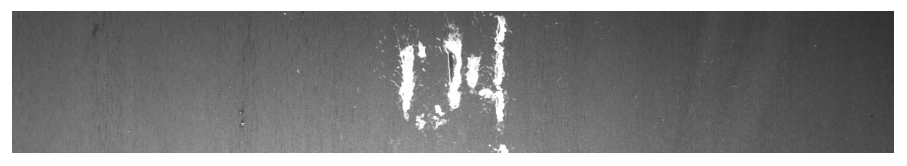

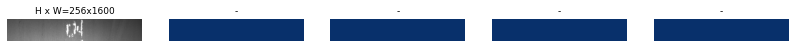

1
image_id  1 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//0a5a82b86.jpg
image                    shape: (256, 1600, 3)        min:    1.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 0)        min:             max:             bool
class_ids                shape: (0,)                  min:             max:             int32
bbox                     shape: (0, 4)                min:             max:             int32

*** No instances to display *** 



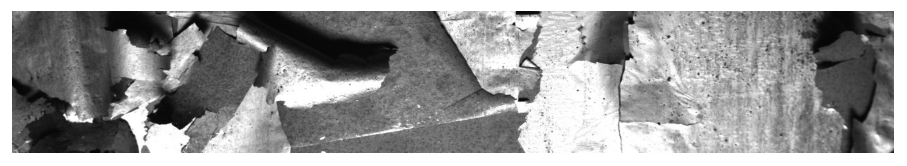

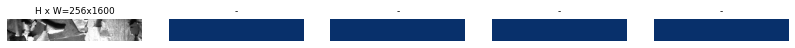

2
image_id  2 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//0a9a7a6c7.jpg
image                    shape: (256, 1600, 3)        min:    2.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 2)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    3.00000  max:    3.00000  int32
bbox                     shape: (2, 4)                min:    0.00000  max: 1239.00000  int32


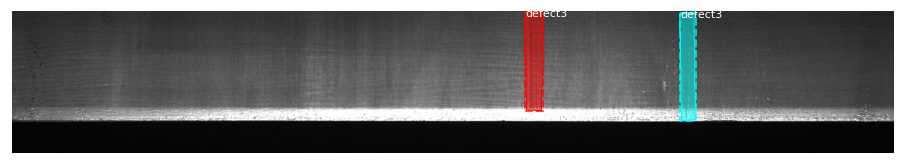

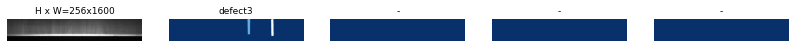

3
image_id  3 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//0a34e73df.jpg
image                    shape: (256, 1600, 3)        min:   20.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 0)        min:             max:             bool
class_ids                shape: (0,)                  min:             max:             int32
bbox                     shape: (0, 4)                min:             max:             int32

*** No instances to display *** 



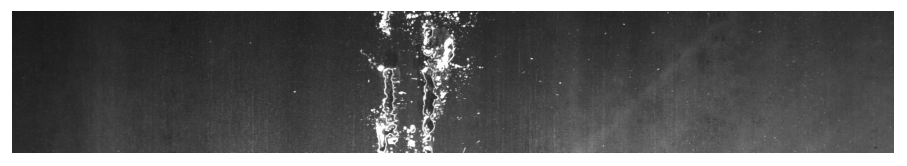

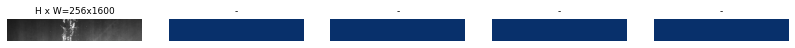

In [7]:
# Load example images and masks.
#files = ['000a4bcdd.jpg', '000f6bf48.jpg', '00ac8372f.jpg', '00af2671f.jpg']
files = ['00fe04c98.jpg','0a5a82b86.jpg','0a9a7a6c7.jpg','0a34e73df.jpg','0a76ac9b8.jpg','0a76c7934.jpg','0a122ef42.jpg']
dataset = SteelDataset()
print(ROOT_DIR)
dataset.load_steel(ROOT_DIR, files)
dataset.prepare()

image_ids = [0,1,2,3] 
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # Compute Bounding box
    bbox = utils.extract_bboxes(mask)
    # Display image and additional stats
    print("image_id ", image_id, dataset.image_reference(image_id))
    log("image", image)
    log("mask", mask)
    log("class_ids", class_ids)
    log("bbox", bbox)
    # Display image and instances
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [5]:
# select files for test and validation dataset
# Load annotations CSV
annotations_train = pd.read_csv(r'C:\Users\HPDQ\Mask_RCNN\DATASET\severstal\train.csv')

# Remove images without Encoding
#annotations_train_Encoded = annotations_train[annotations_train['EncodedPixels'].notna()].copy()        
annotations_train_Encoded = annotations_train
# Split ImageId_ClassId
#ImageId_ClassId_split = annotations_train_Encoded["ImageId_ClassId"].str.split("_", n = 1, expand = True)
#annotations_train_Encoded['ImageId'] = ImageId_ClassId_split.loc[:,0]
#annotations_train_Encoded['ClassId'] = ImageId_ClassId_split.loc[:,1]

# Split dataframe
msk = np.random.rand(len(annotations_train_Encoded)) < 0.8
train_msk = annotations_train_Encoded[msk]
val_msk = annotations_train_Encoded[~msk]
train = train_msk['ImageId'].unique().copy()
val = val_msk['ImageId'].unique().copy()
print('Train images: ' + str(len(train)))
print('Test images: ' + str(len(val)))
# Cleanup
#del annotations_train, annotations_train_Encoded, msk, train_msk, val_msk 
#gc.collect()

Train images: 5380
Test images: 1433


(7095,)

(5469,)

In [6]:
# Training preperations
# Training dataset
dataset_train = SteelDataset()
dataset_train.load_steel(ROOT_DIR, train)
dataset_train.prepare()

# Validation dataset
dataset_val = SteelDataset()
dataset_val.load_steel(ROOT_DIR, val)
dataset_val.prepare()
augmentation = iaa.SomeOf((0, 2), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270)]),
    iaa.Multiply((0.8, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

# Build training model
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
COCO_MODEL_PATH = r"C:\Users\HPDQ\Mask_RCNN\mask_rcnn_coco.h5"
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
# Required due to change in new Tensorflow / Keras version
model.keras_model.metrics_tensors = []
# Load weights to continue training
# model.load_weights(Trained_Weights, by_name=True)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [ ]:
# Train model
#timestart = timeit.default_timer()
print("Training")
model.train(dataset_train, 
            dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=config.EPOCHS,
            augmentation=augmentation,
            layers='all')
#print ('Total run time: ' + str(runtime) + ' minutes')

Training

Starting at epoch 0. LR=0.0001

Checkpoint Path: logs\steel20211014T2004\mask_rcnn_steel_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/20
3269
 36/100 [=========>....................] - ETA: 42:36 - loss: 4.2165 - rpn_class_loss: 0.1515 - rpn_bbox_loss: 3.1198 - mrcnn_class_loss: 0.6730 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.09674315


 76/100 [=====================>........] - ETA: 15:50 - loss: 3.3813 - rpn_class_loss: 0.1407 - rpn_bbox_loss: 2.4245 - mrcnn_class_loss: 0.3611 - mrcnn_bbox_loss: 0.2786 - mrcnn_mask_loss: 0.17642213


 99/100 [============================>.] - ETA: 39s - loss: 3.1841 - rpn_class_loss: 0.1454 - rpn_bbox_loss: 2.2058 - mrcnn_class_loss: 0.3062 - mrcnn_bbox_loss: 0.3092 - mrcnn_mask_loss: 0.2175 5161
1190
1309
942
192
176
100/100 [==============================] - 4009s 40s/step - loss: 3.1692 - rpn_class_loss: 0.1460 - rpn_bbox_loss: 2.1986 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.3061 - mrcnn_mask_loss: 0.2153 - val_loss: 2.4881 - val_rpn_class_loss: 0.1270 - val_rpn_bbox_loss: 1.7835 - val_mrcnn_class_loss: 0.1821 - val_mrcnn_bbox_loss: 0.2101 - val_mrcnn_mask_loss: 0.1855

Epoch 2/20
18
 14/100 [===>..........................] - ETA: 57:18 - loss: 2.4190 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 1.4479 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.4340 - mrcnn_mask_loss: 0.39571795


 54/100 [===============>..............] - ETA: 30:41 - loss: 2.1811 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.3375 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.3402 - mrcnn_mask_loss: 0.35774985


 94/100 [===========================>..] - ETA: 3:59 - loss: 2.0592 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 1.2300 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.3433 - mrcnn_mask_loss: 0.3479862


 99/100 [============================>.] - ETA: 39s - loss: 2.0884 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.2497 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.3426 - mrcnn_mask_loss: 0.3589 2199
908
1226
356
1298
1283
100/100 [==============================] - 4053s 41s/step - loss: 2.0935 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 1.2476 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.3443 - mrcnn_mask_loss: 0.3630 - val_loss: 1.6992 - val_rpn_class_loss: 0.0383 - val_rpn_bbox_loss: 1.6589 - val_mrcnn_class_loss: 0.0020 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/20
4613
 33/100 [========>.....................] - ETA: 44:35 - loss: 2.1413 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.2880 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.3787 - mrcnn_mask_loss: 0.35473047


 73/100 [====================>.........] - ETA: 17:56 - loss: 1.9958 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.1738 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.3754 - mrcnn_mask_loss: 0.32524501


 99/100 [============================>.] - ETA: 39s - loss: 1.9700 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 1.2116 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.3434 - mrcnn_mask_loss: 0.3046 4954
689
5
545
1341
1060
100/100 [==============================] - 4036s 40s/step - loss: 1.9774 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.2084 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.3500 - mrcnn_mask_loss: 0.3082 - val_loss: 1.5047 - val_rpn_class_loss: 0.0551 - val_rpn_bbox_loss: 1.1565 - val_mrcnn_class_loss: 0.0408 - val_mrcnn_bbox_loss: 0.0899 - val_mrcnn_mask_loss: 0.1624
Epoch 4/20
3958
 12/100 [==>...........................] - ETA: 58:15 - loss: 2.0670 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 1.2099 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.3600 - mrcnn_mask_loss: 0.3697529


 52/100 [==============>...............] - ETA: 32:00 - loss: 2.0444 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 1.1643 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.3562 - mrcnn_mask_loss: 0.37534047


 92/100 [==========================>...] - ETA: 5:21 - loss: 2.0538 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.1376 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.38551824


 99/100 [============================>.] - ETA: 40s - loss: 2.0441 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 1.1359 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.3849 4769
793
1338
145
487
1106
100/100 [==============================] - 4082s 41s/step - loss: 2.0501 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 1.1495 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.3799 - mrcnn_mask_loss: 0.3811 - val_loss: 2.3598 - val_rpn_class_loss: 0.0250 - val_rpn_bbox_loss: 1.5074 - val_mrcnn_class_loss: 0.0819 - val_mrcnn_bbox_loss: 0.2559 - val_mrcnn_mask_loss: 0.4896
Epoch 5/20
578
 31/100 [========>.....................] - ETA: 45:40 - loss: 2.1629 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.2095 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.3533 - mrcnn_mask_loss: 0.4186943


 71/100 [====================>.........] - ETA: 19:14 - loss: 2.1037 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.1822 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.3505 - mrcnn_mask_loss: 0.3996896


 99/100 [============================>.] - ETA: 39s - loss: 2.1643 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.2101 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.3821 - mrcnn_mask_loss: 0.3994 612
98
265
186
900
102
100/100 [==============================] - 4036s 40s/step - loss: 2.1576 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.2125 - mrcnn_class_loss: 0.1287 - mrcnn_bbox_loss: 0.3782 - mrcnn_mask_loss: 0.3954 - val_loss: 1.7526 - val_rpn_class_loss: 0.0321 - val_rpn_bbox_loss: 0.7503 - val_mrcnn_class_loss: 0.2247 - val_mrcnn_bbox_loss: 0.2519 - val_mrcnn_mask_loss: 0.4936
Epoch 6/20
4914
 10/100 [==>...........................] - ETA: 59:26 - loss: 2.2202 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 1.1316 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.4953 - mrcnn_mask_loss: 0.4962  2746


 50/100 [==============>...............] - ETA: 33:04 - loss: 2.0864 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 1.0834 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.4382 - mrcnn_mask_loss: 0.4445199


 90/100 [==========================>...] - ETA: 6:36 - loss: 2.1543 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 1.0503 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.4825 - mrcnn_mask_loss: 0.4801130


 99/100 [============================>.] - ETA: 39s - loss: 2.1379 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 1.0436 - mrcnn_class_loss: 0.1153 - mrcnn_bbox_loss: 0.4758 - mrcnn_mask_loss: 0.4729 3438
1164
280
259
104
1328
100/100 [==============================] - 4022s 40s/step - loss: 2.1487 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 1.0432 - mrcnn_class_loss: 0.1210 - mrcnn_bbox_loss: 0.4782 - mrcnn_mask_loss: 0.4759 - val_loss: 2.6926 - val_rpn_class_loss: 0.0475 - val_rpn_bbox_loss: 1.0497 - val_mrcnn_class_loss: 0.0865 - val_mrcnn_bbox_loss: 0.7962 - val_mrcnn_mask_loss: 0.7127
Epoch 7/20
3036
 29/100 [=======>......................] - ETA: 46:51 - loss: 2.1881 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 1.1765 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.4304 - mrcnn_mask_loss: 0.4598652


 69/100 [===================>..........] - ETA: 20:28 - loss: 2.1716 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 1.1754 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.4093 - mrcnn_mask_loss: 0.46491313


 99/100 [============================>.] - ETA: 39s - loss: 2.1347 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 1.1443 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.4161 - mrcnn_mask_loss: 0.4581 328
230
635
1040
954
75
100/100 [==============================] - 4018s 40s/step - loss: 2.1579 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 1.1769 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.4119 - mrcnn_mask_loss: 0.4535 - val_loss: 2.2098 - val_rpn_class_loss: 0.0140 - val_rpn_bbox_loss: 0.9464 - val_mrcnn_class_loss: 0.2301 - val_mrcnn_bbox_loss: 0.4687 - val_mrcnn_mask_loss: 0.5506
Epoch 8/20
957
  8/100 [=>............................] - ETA: 1:01:14 - loss: 2.3878 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.7257 - mrcnn_class_loss: 0.2039 - mrcnn_bbox_loss: 0.7038 - mrcnn_mask_loss: 0.72874132


 48/100 [=============>................] - ETA: 34:26 - loss: 2.3343 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 1.0687 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.5272 - mrcnn_mask_loss: 0.54855252


 88/100 [=========================>....] - ETA: 7:56 - loss: 2.1654 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 1.0158 - mrcnn_class_loss: 0.1341 - mrcnn_bbox_loss: 0.4783 - mrcnn_mask_loss: 0.5109133


 99/100 [============================>.] - ETA: 39s - loss: 2.1669 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.0155 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.4747 - mrcnn_mask_loss: 0.5089 1914
148
870
811
806
1031
100/100 [==============================] - 4030s 40s/step - loss: 2.1711 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 1.0307 - mrcnn_class_loss: 0.1387 - mrcnn_bbox_loss: 0.4700 - mrcnn_mask_loss: 0.5038 - val_loss: 1.9807 - val_rpn_class_loss: 0.0113 - val_rpn_bbox_loss: 0.8769 - val_mrcnn_class_loss: 0.1632 - val_mrcnn_bbox_loss: 0.3990 - val_mrcnn_mask_loss: 0.5303
Epoch 9/20
4059
 27/100 [=======>......................] - ETA: 48:19 - loss: 2.4717 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 1.0667 - mrcnn_class_loss: 0.1449 - mrcnn_bbox_loss: 0.6380 - mrcnn_mask_loss: 0.60114168


 67/100 [===================>..........] - ETA: 21:49 - loss: 2.3049 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 1.1255 - mrcnn_class_loss: 0.1284 - mrcnn_bbox_loss: 0.5151 - mrcnn_mask_loss: 0.51444377


 99/100 [============================>.] - ETA: 39s - loss: 2.2600 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 1.1032 - mrcnn_class_loss: 0.1245 - mrcnn_bbox_loss: 0.4954 - mrcnn_mask_loss: 0.5132 1793
589
618
101
87
976
100/100 [==============================] - 4035s 40s/step - loss: 2.2556 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 1.0983 - mrcnn_class_loss: 0.1237 - mrcnn_bbox_loss: 0.4957 - mrcnn_mask_loss: 0.5143 - val_loss: 1.7039 - val_rpn_class_loss: 0.0169 - val_rpn_bbox_loss: 0.7133 - val_mrcnn_class_loss: 0.0937 - val_mrcnn_bbox_loss: 0.3602 - val_mrcnn_mask_loss: 0.5198
Epoch 10/20
617
  6/100 [>.............................] - ETA: 1:02:10 - loss: 1.8353 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.0700 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.2852 - mrcnn_mask_loss: 0.42861782


 46/100 [============>.................] - ETA: 36:11 - loss: 1.9913 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.9211 - mrcnn_class_loss: 0.1507 - mrcnn_bbox_loss: 0.4083 - mrcnn_mask_loss: 0.48382159


 86/100 [========================>.....] - ETA: 9:22 - loss: 2.0826 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.9136 - mrcnn_class_loss: 0.1647 - mrcnn_bbox_loss: 0.4601 - mrcnn_mask_loss: 0.5164 4072


 99/100 [============================>.] - ETA: 40s - loss: 2.0943 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.9144 - mrcnn_class_loss: 0.1666 - mrcnn_bbox_loss: 0.4617 - mrcnn_mask_loss: 0.5231 2633
1413
838
1167
77
687
100/100 [==============================] - 4070s 41s/step - loss: 2.0980 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.9155 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.4617 - mrcnn_mask_loss: 0.5247 - val_loss: 2.3014 - val_rpn_class_loss: 0.0056 - val_rpn_bbox_loss: 0.9487 - val_mrcnn_class_loss: 0.1698 - val_mrcnn_bbox_loss: 0.5518 - val_mrcnn_mask_loss: 0.6255
Epoch 11/20
2973
 25/100 [======>.......................] - ETA: 50:05 - loss: 2.2445 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 1.1417 - mrcnn_class_loss: 0.1757 - mrcnn_bbox_loss: 0.4287 - mrcnn_mask_loss: 0.47212568


 65/100 [==================>...........] - ETA: 23:00 - loss: 2.1822 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 1.0659 - mrcnn_class_loss: 0.1777 - mrcnn_bbox_loss: 0.4385 - mrcnn_mask_loss: 0.47595104


 99/100 [============================>.] - ETA: 39s - loss: 2.1880 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 1.0537 - mrcnn_class_loss: 0.1745 - mrcnn_bbox_loss: 0.4472 - mrcnn_mask_loss: 0.4888 2232
901
27
1365
378
560
100/100 [==============================] - 3972s 40s/step - loss: 2.1836 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 1.0472 - mrcnn_class_loss: 0.1736 - mrcnn_bbox_loss: 0.4481 - mrcnn_mask_loss: 0.4912 - val_loss: 2.2521 - val_rpn_class_loss: 0.0153 - val_rpn_bbox_loss: 1.4464 - val_mrcnn_class_loss: 0.0354 - val_mrcnn_bbox_loss: 0.3823 - val_mrcnn_mask_loss: 0.3726
Epoch 12/20
5102
  4/100 [>.............................] - ETA: 1:00:15 - loss: 1.3333 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 1.0081 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1443            3814


 44/100 [============>.................] - ETA: 36:46 - loss: 2.0528 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.9826 - mrcnn_class_loss: 0.1335 - mrcnn_bbox_loss: 0.3968 - mrcnn_mask_loss: 0.51521556


 66/100 [==================>...........] - ETA: 4:39:00 - loss: 2.1800 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 1.0444 - mrcnn_class_loss: 0.1536 - mrcnn_bbox_loss: 0.4420 - mrcnn_mask_loss: 0.5150776


In [ ]:
history = model.keras_model.history.history
epochs = range(1, config.EPOCHS + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.show()

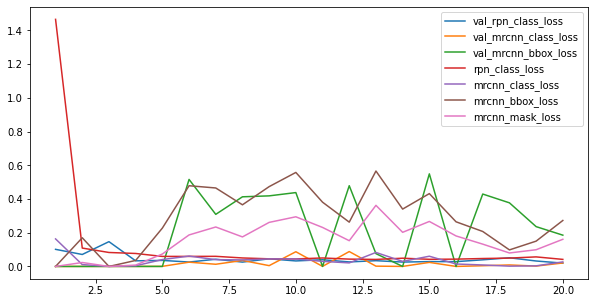

In [19]:
history = model.keras_model.history.history
epochs = range(1, config.EPOCHS + 1)
plt.figure(figsize=(10,5))
#plt.plot(epochs, history['val_loss'], label="valid loss")
plt.plot(epochs, history['val_rpn_class_loss'], label="val_rpn_class_loss")
#plt.plot(epochs, history['val_rpn_bbox_loss'], label="val_rpn_bbox_loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="val_mrcnn_class_loss")
plt.plot(epochs, history['val_mrcnn_bbox_loss'], label="val_mrcnn_bbox_loss")
#plt.plot(epochs, history['val_mrcnn_mask_loss'], label="val_mrcnn_mask_loss")
#plt.plot(epochs, history['loss'], label="loss")
plt.plot(epochs, history['rpn_class_loss'], label="rpn_class_loss")
#plt.plot(epochs, history['rpn_bbox_loss'], label="rpn_bbox_loss")
plt.plot(epochs, history['mrcnn_class_loss'], label="mrcnn_class_loss")
plt.plot(epochs, history['mrcnn_bbox_loss'], label="mrcnn_bbox_loss")
plt.plot(epochs, history['mrcnn_mask_loss'], label="mrcnn_mask_loss")
plt.legend()
plt.show()

In [15]:
history

{'val_loss': [2.8173218965530396,
  1.4922582507133484,
  1.9980790853500365,
  1.674442505836487,
  2.5728445053100586,
  2.2907999992370605,
  2.026926064491272,
  1.6393550515174866,
  2.2538417100906374,
  1.8431158542633057,
  1.3013492465019225,
  1.9546568393707275,
  1.298164176940918,
  1.4246692538261414,
  2.1555988788604736,
  1.2483531832695007,
  1.9751682043075562,
  2.364489662647247,
  2.5082118988037108,
  2.1014114379882813],
 'val_rpn_class_loss': [0.1014690414071083,
  0.07098336555063725,
  0.14703837148845195,
  0.033322017267346384,
  0.035794921591877936,
  0.026150450855493546,
  0.04272837154567242,
  0.0257661709561944,
  0.04528110194951296,
  0.03268857095390558,
  0.03981079161167145,
  0.02677457556128502,
  0.034167378954589364,
  0.025957390666007996,
  0.028748981282114984,
  0.028558395430445672,
  0.039284972846508025,
  0.05147067531943321,
  0.03231751844286919,
  0.019790316745638848],
 'val_rpn_bbox_loss': [2.715814709663391,
  1.421111917495727

In [9]:
class InferenceConfig(SteelConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [11]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
#COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
COCO_MODEL_PATH = r"C:\Users\HPDQ\Mask_RCNN\mask_rcnn_coco.h5"

In [19]:
class InferenceConfig(SteelConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = r"C:\Users\HPDQ\Mask_RCNN\logs\steel20211009T0844\mask_rcnn_steel_0020.h5"
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\HPDQ\Mask_RCNN\logs\steel20211009T0844\mask_rcnn_steel_0020.h5
Re-starting from epoch 20


In [20]:
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1600.00000  float64
gt_class_id              shape: (3,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:  430.00000  max:  806.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool


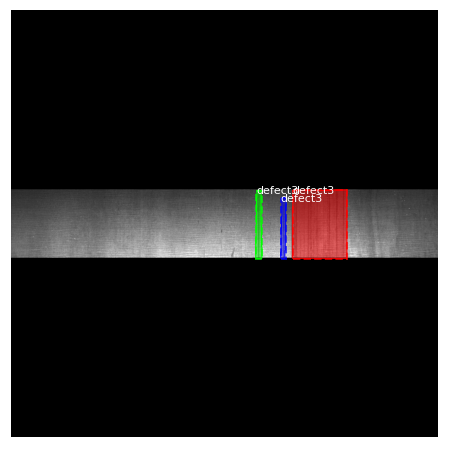

In [21]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [22]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


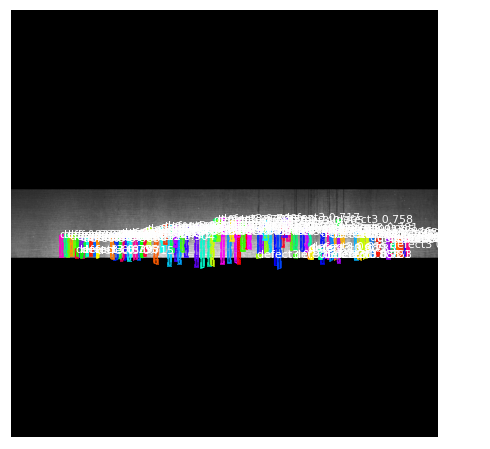

In [23]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [39]:
dataset_train